<div style="text-align:center;">
<h2>KV260 Üzerinde Yorumlarıyla AI Destekli Tümör Segmentasyon Sistemi</h2>
<h3>AI-Driven Tumor Segmentation System with Annotation on KV260</h3>

<hr/>
<ul style="display: flex; gap: 50px; justify-content: center;">
<li>Abdel Manan A. R.</li>
<li>Alperen Şahin</li>
<li>Sezen Bal</li>
</ul>
<p style="text-align:center;font-size: 18px;">Marmara Universitesi (Teknoloji Fakultesi) </p>
<p style="text-align:center;font-size: 12px;">Elektrik ve Elektronik Muh.</p>
<p style="text-align:center;font-size: 12px;">Ileri Sayisal Tasarim <b>(Sezen Bal)</b></p>
<a style="text-align:center;" href="https://github.dev/amar-jay/ileri_sayisal/blob/main/ileri_sayisal_tr.ipynb">
	<img src="https://img.shields.io/github/followers/amar-jay?label=Follow&style=social"/>
	<p style="text-align:center;"> https://github.com/amar-jay/ileri_sayisal </p>
</a>
</div>



## Visualize dataset

Bu betik, LITS veri setini PyTorch'ta eğitim ve değerlendirme için işler ve hazırlar. Karaciğerin `.nii` formatındaki CT taramaları ve karaciğer ile tümörler için segmentasyon maskeleri içerir. Karaciğer segmentasyonu görevleri için tıbbi görüntüleme araştırmalarında yaygın olarak kullanılır.

#### `LITSDataset`'in Temel Özellikleri

- `.nii` 3D dosyalarının y ekseninde 2D dilimlere dönüştürülmesi
- Bozulmuş verilerin filtrelenmesi
- Veri setinin bölünmesi (Eğitim / Test seti)
- `LITSImageTransform` aracılığıyla özel dönüşümlerin uygulanması (yeniden boyutlandırma, normalizasyon ve kırpma gibi)


In [1]:
# fetching dataset
from dataset import LITSDataset, LITSImageTransform
import torch
dataset = LITSDataset(
    images_dir="./dataset/",
    masks_dir="./dataset/",
    slice_axis=2,
    transform=LITSImageTransform(),
    test_size=4,
    split="test"
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

for sample in dataloader:
    print(sample.keys())
    break

len(dataset),len(dataloader), dataset, dataloader


dict_keys(['image', 'mask', 'image_path', 'slice_idx'])


(4,
 1,
 <torch.utils.data.dataloader.DataLoader at 0x7f49817dc400>)

In [7]:
import numpy as np
# finding average mean of each sample, to find percentage of unsegmented samples
# this was done, when trying prior to creation of the create_slice_mapping in dataset. 
# since after training it didn't segment due to over 50% of mask empty
averages = []
non_zeros = []
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
VAL=0.2 # now can test with 
total = 0
for i, sample in enumerate(dataloader):
    if i > 15:
        break
    x = sample["mask"]
    avgs = x.view(x.size(0), -1).float().mean(1, keepdim=True)
    total += len(avgs)
    zeros = [np.count_nonzero(x[i]) for i in range(x.size(0))]
    non_zeros += [zero for zero in zeros if zero > 0]
    averages += [i.item() for i in avgs if i.item() > VAL]

print(len(averages), len(non_zeros), total)
print(f"average of masked samples with avg > {VAL} out of {total}: {len(averages)*100/total:.3f}%, non zeros: {len(non_zeros)*100/total:.3f}%")

3 64 64
average of masked samples with avg > 0.2 out of 64: 4.688%, non zeros: 100.000%


Yukarıdaki verilere göre, örneklerin yaklaşık **%5'inin tümör boyutu** kendi boyutunun **%20'sinden daha büyük** olduğunu görebiliyoruz. Bu nedenle, büyük tümörler üzerinde çıkarım yaparak modelin doğruluğunu test etmeyi hedefliyoruz.

Ayrıca, tümör içermeyen dilimleri filtreledik, yani hastanın torasik bölgesinde yer almayan vücut kısımlarını.

Söylediklerimi doğrulamak için, aşağıda hastanın boyu boyunca **%10**, **%50** ve **%90** dilimlerinde yapılan görselleştirmeleri sunuyoruz. Gördüğümüz kadarıyla, hastanın karaciğer bölgesi (yani ilgi alanı/karaciğer bölgesi) **%40-%60** arası, yani orta kısımda yer alıyor. Bu nedenle, veri setimizi **%40-%60** arasındaki dilimlere ve yaklaşık **15 dilime** dayanarak oluşturuyoruz. Bu dilimler, görüntü veri setinde benzerlikleri önlemek amacıyla eşit aralıklarla yayılmıştır.

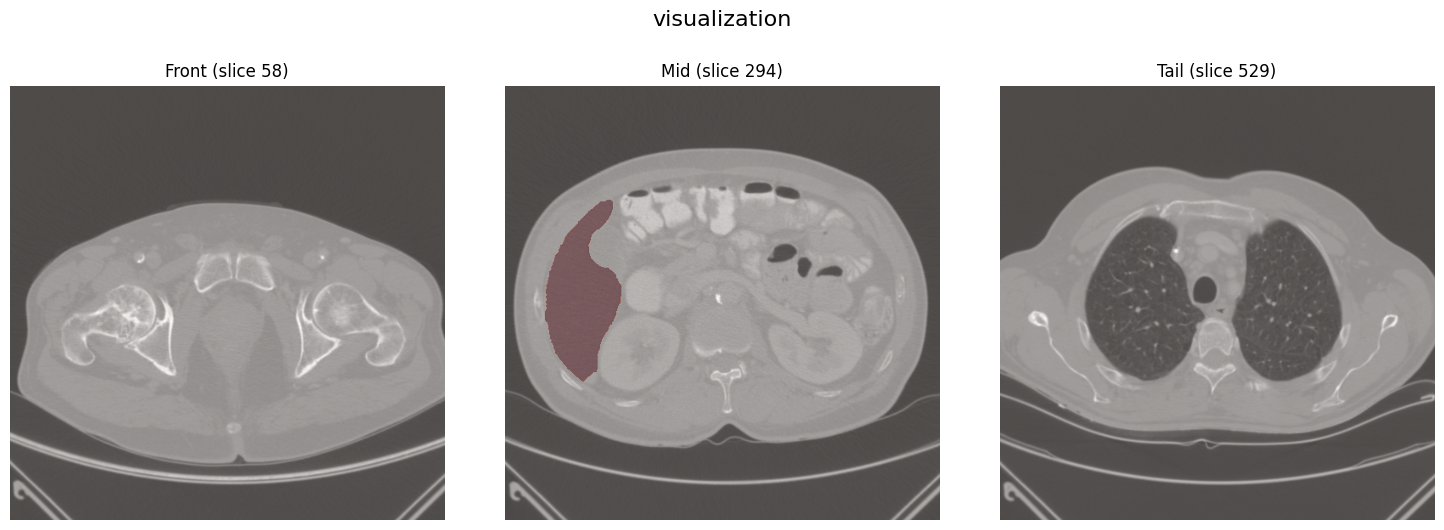

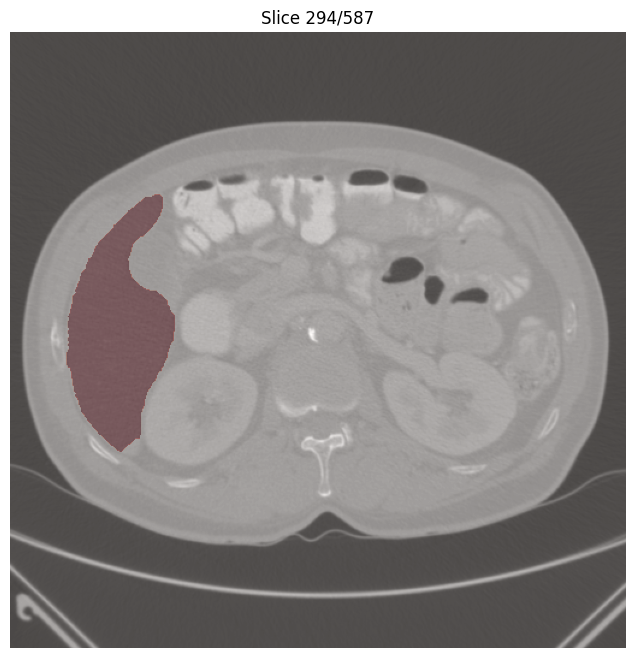

In [15]:
import os

# Load and visualize both the image and mask NIfTI files
num = 14
image_path = f"../dataset/nii/volume-{num}.nii"
mask_path = f"../dataset/nii/segmentation-{num}.nii"

assert os.path.exists(image_path)
assert os.path.exists(mask_path)

# Basic static visualization
_ = visualize_nii(
    nii_path=image_path,
    mask_path=mask_path, 
    cmap='gray',
    mask_alpha=0.3  
)

# # Or use the interactive slice browser
_ = create_slice_browser(
    nii_path=image_path,
    mask_path=mask_path,
    axis=2               # 0: sagittal, 1: coronal, 2: axial
)

Ancak, daha yakından incelediğimizde, birçok bozulmuş `.nii` dosyasının varlığı büyük bir zorluk oluşturdu. Bu durum, kullanılabilir veriyi en üst düzeye çıkarmak için mümkün olduğunca fazla görüntü üretmemize sebep oldu ve dilimler arasındaki yakınlık nedeniyle önemli benzerlikler oluştu. Diğer taraftan, dilimleri daha uzak aralıklardan örneklemek, kullanılabilir veri örneklerinin sayısını azalttı, bu da bir **denge** oluşturdu ve veri seti oluşturma sürecindeki **dilemmamızı** gözler önüne serdi.

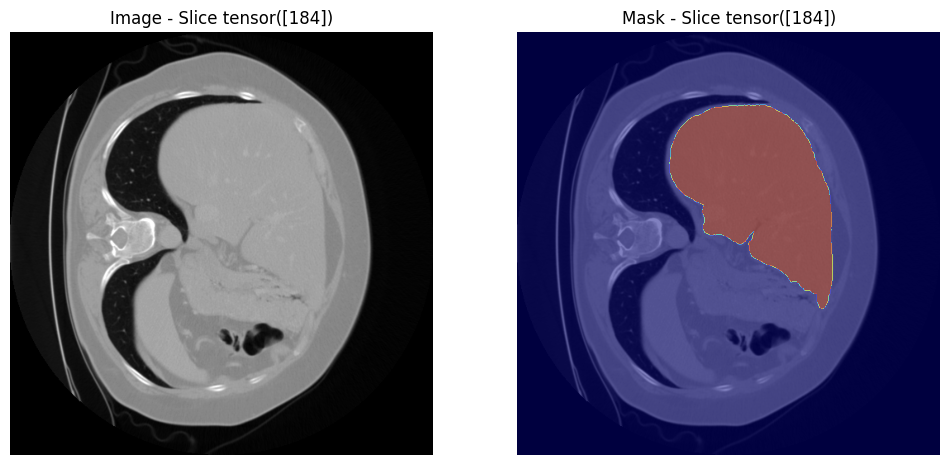

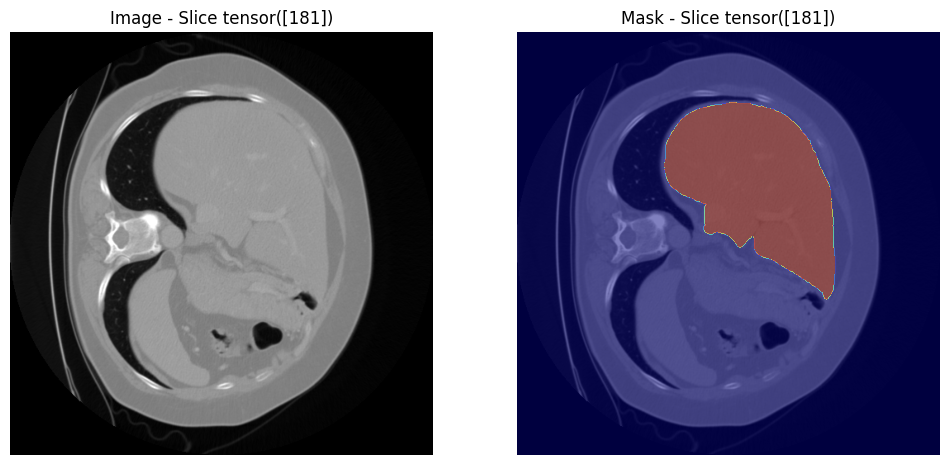

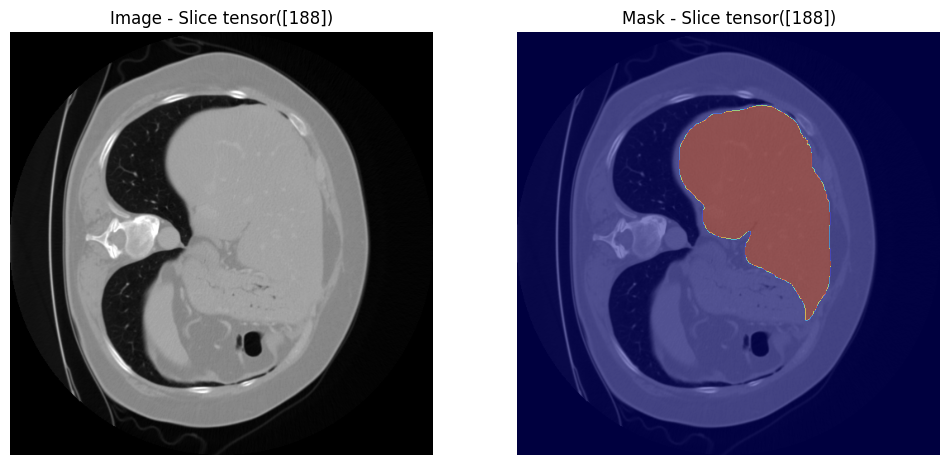

In [5]:
from visualize import *

_ = visualize_from_loader(dataloader, num_samples=3)

## Train model

Eğitim aşamasında, model PyTorch ile implement edildi ve Lightning AI platformunda GPU hızlandırması kullanılarak eğitildi. Önceden eğitilmiş Deeplab'ın ResNet modeli, özellikle veri setimize uyacak şekilde ince ayar yapıldı. Mevcut betiklerle uyumluluk sorunlarını önlemek amacıyla, eğitim için bir CLI tabanlı yaklaşım benimsedik.

Model, aynı veri seti üzerinde beş kez eğitildi, bu da muhtemelen bu veri setine karşı bir **önyargı** oluşturdu. Maalesef, bu sınırlama yalnızca eğitim sonunda fark edildi ve yeniden eğitim için yeterli zaman ve kaynak sağlanamadı.

Eğitilen model ağırlıkları, `build/f_large_model.pth` olarak kaydedildi.

Ağırlıkların büyük boyutu nedeniyle, platformun depolama sınırlarını aşması sebebiyle GitHub depolama alanına dahil edilemediler.

In [2]:
## Train model
!python3 train.py -d=cuda:0 --batch_size=8 --epoch=5 


 Namespace(build_path='build', device='cuda:0', epochs=5, batch_size=8, use_small=False) 
 --------
^C
Traceback (most recent call last):
  File "/teamspace/studios/this_studio/ileri_sayisal/train.py", line 161, in <module>
    dataset = LITSDataset(
  File "/teamspace/studios/this_studio/ileri_sayisal/dataset.py", line 38, in __init__
    slices_mapping = self._create_slices_mapping()
  File "/teamspace/studios/this_studio/ileri_sayisal/dataset.py", line 69, in _create_slices_mapping
    volume = img.get_fdata()
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/nibabel/dataobj_images.py", line 374, in get_fdata
    data = np.asanyarray(self._dataobj, dtype=dtype)
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/nibabel/arrayproxy.py", line 454, in __array__
    arr = self._get_scaled(dtype=dtype, slicer=())
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/nibabel/arrayproxy.py", line 423, in _get_scaled
    

Bu betik, modelin doğruluğunu iki metrik kullanarak veri seti üzerinde değerlendirir: **piksel doğruluğu** ve **Intersection over Union (IoU)**.

**Test Sonuçları**:

- Model, eğitim veri setindeki görüntülerle aynı oryantasyona sahip görüntülerde etkileyici doğruluk **(≥ %95)** elde etti.
- Ancak, yakınlaştırma, kırpma veya oryantasyon gibi değişikliklere sahip görüntülerde performans önemli ölçüde düştü **(~%75)**, bu da modelin bu farklara karşı duyarlılığını gözler önüne serdi.

Eğitim aşamasına benzer şekilde, test süreci de CLI tabanlı bir yaklaşım kullanılarak gerçekleştirildi.

In [ ]:
!python3 test.py -d=cuda:0 --batch_size=8 -w=./build/f_large_model.pth 

## Make inference

In [3]:
import os
from train import get_model_large
save_path="./build/f_large_model.pth"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

assert os.path.exists(save_path)

model = get_model_large(3, save_path, device=device) 



Loading weights from local directory: ./build/f_large_model.pth


Bu, en büyük tümör görüntü diliminin tek tek karşılaştırılmasıdır, çünkü daha büyük tümörler genellikle daha yüksek tahmin doğruluğu ile sonuçlanır.

Bu görselleştirmede:

- **Üst**: Veri setinden alınan gerçek görüntü maskesi dilimi.
- **Alt**: Model tarafından üretilen tahmin edilen görüntü maskesi dilimi.

Actual


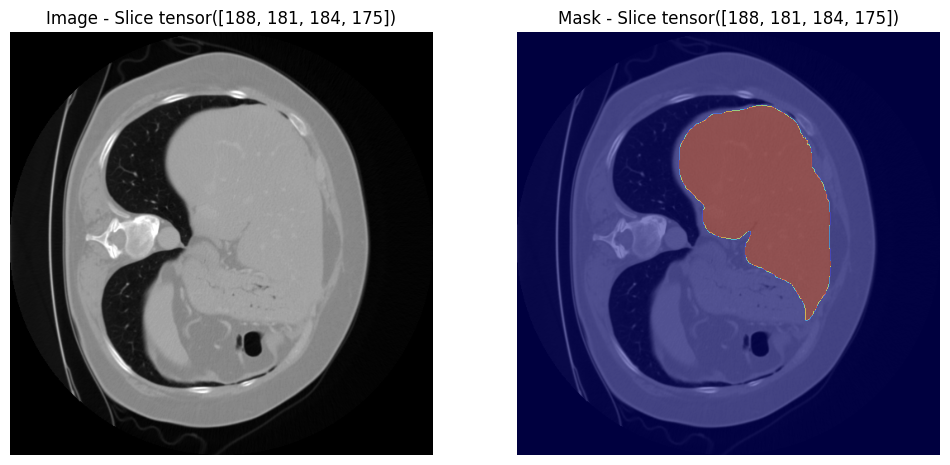

torch.Size([4, 512, 512]) tensor([0, 1]) torch.int64
Predictions


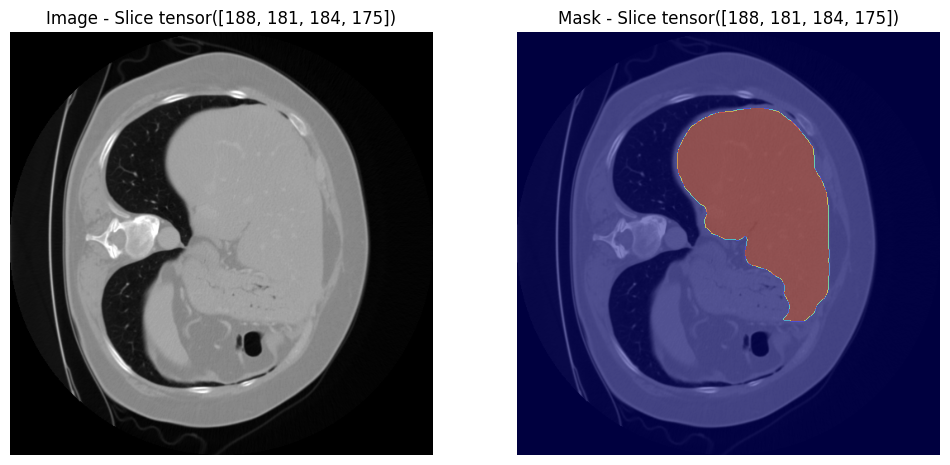

In [35]:
from torch.nn import functional as F
for sample in dataloader:
    print("Actual")
    visualize_sample(sample)
    images = sample['image'].to(device)  # Shape: [B, 1, 512, 512]
    masks = sample['mask'].to(device)    # Shape: [B, 512, 512]

        # Repeat the channels for a 3-channel input
    images = images.repeat(1, 3, 1, 1)
    # Forward pass
    outputs = model(images)["out"]
    outputs_prob = F.softmax(outputs, dim=1)
    preds = torch.argmax(outputs_prob, dim=1)  # Get predicted class for each pixel

    pred_sample = {
        'image': sample['image'],
        'slice_idx': sample['slice_idx'],
        'mask': preds
    }
        # pred_sample = sample.copy()
        # pred_sample['mask'] = preds
    print("Predictions")
    visualize_sample(pred_sample)
    break


Bu durumda yüksek doğruluğun nedeni, daha büyük tümörlerin görüntülerde daha belirgin ve kolayca tanımlanabilir özelliklere sahip olmasıdır. Bu, modelin maskeyi doğru bir şekilde öğrenmesini ve tahmin etmesini kolaylaştırır. Sonuç olarak, tahmin edilen maske, gerçek maske ile neredeyse özdeştir ve bu, modelin büyük tümörler üzerindeki güçlü performansını gösterir.

Modeli daha fazla test etmek amacıyla, veri setinden en büyük 64 tümör diliminin gösterildiği bir video kullandık. Bu video, gerçekçi tutarsızlıklar ve varyasyonlar eklemek amacıyla Tablet cihazımızda görüntülendi. Değerlendirme için kullanılan orijinal videoyu aşağıdaki bağlantıdan izleyebilirsiniz:

- [En Büyük 64 Tümör Dilimi ile Orijinal Video](https://github.com/amar-jay/ileri_sayisal/raw/refs/heads/main/video_2025-01-13_00-20-03.mp4)

Modelin çıkarım işlemi sonrasında, tümörleri nasıl tespit ettiğini görselleştirmek için videoyu segmentlere ayırdık. Modelin tahmin ettiği tümör alanlarını vurgulayan segmentlenmiş videoyu aşağıdaki bağlantıdan erişebilirsiniz:

- [Segmentlenmiş Video (Modelin Tahminleri)](https://github.com/amar-jay/ileri_sayisal/raw/refs/heads/main/output_segmented_video.mp4) yada [bunu (kirmizi-mavi)](https://github.com/amar-jay/ileri_sayisal/raw/refs/heads/main/output_segmented_video_.mp4)


### Video Segmentasyonunun İncelenmesi

Video segmentasyonu sonrasında yaptığımız incelemede, modelin tümörü tespit etmekte başarılı olduğunu ancak görüntü dışında ve tümör bölgesi dışında bazı alanları yanlış tespit ettiğini fark ettik. Bu konuda bazı zorluklar yaşadık. Unutmayın, bu **en büyük 64 tümör bölgesi** üzerindeki testleri gerçekleştirdik.

Deneyin sonunda, modelin yüksek doğruluk gösterdiği ancak bazı sınırlamaları olduğu açıkça ortaya çıktı. Bu sınırlamalar, eğitim sırasında kötü görüntü dönüşümleri veya veri setine aşırı uyum sağlanması gibi faktörlere bağlanabilir. Yine de, model, KV260'da çalışacak kadar küçük olması gerektiği düşünüldüğünde, boyutuna göre yeterince iyi durumda kalmaktadır.



## Inference with a video

In [6]:
# !sudo apt install python3-opencv
# !pip install opencv-python moviepy
from IPython.display import Video, display
from matplotlib import pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet101
import cv2
import os
from PIL import Image
import numpy as np
from torchvision import transforms
from train import get_model_large
import torch



input_video_path = "/teamspace/studios/this_studio/ileri_sayisal/video_2025-01-13_00-20-03.mp4"
output_video_path = "output_segmented_video.mp4"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

assert os.path.exists(input_video_path)

# Define preprocessing transformation
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define postprocessing function to convert output to a mask
def postprocess(output, original_size):
    output = torch.argmax(output, dim=0).cpu().numpy()
    output = cv2.resize(output, original_size, interpolation=cv2.INTER_NEAREST)
    return output

# model = deeplabv3_resnet101(pretrained=True)
# model = model.to(device)
# model.eval()

save_path="./build/f_large_model.pth"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

assert os.path.exists(save_path)

model = get_model_large(3, save_path, device=device) 


# Create a directory for temporary frame storage
os.makedirs("temp_frames", exist_ok=True)

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = f"temp_frames/frame_{count:04d}.png"
        cv2.imwrite(frame_path, frame)
        count += 1
    
    cap.release()
    return frame_count, fps, frame_size

def segment_frames(frame_count, frame_size, min_area=10000):
    segmented_frames = []
    
    for i in range(frame_count):
        frame_path = f"temp_frames/frame_{i:04d}.png"
        frame = cv2.imread(frame_path)
        original_size = frame.shape[:2]
        input_tensor = preprocess(frame).unsqueeze(0).to(device)
        input_tensor = input_tensor.repeat(4, 1, 1, 1)
        with torch.no_grad():
            # NOTE: still dont know how to sort it out but it needs 4 batches to train., so
            output = model(input_tensor)["out"].squeeze(0)
        
        # using only the first batch
        mask = postprocess(output[0], original_size[::-1])
        color_mask = cv2.applyColorMap((mask * 255).astype(np.uint8), cv2.COLORMAP_BONE)
        overlay = cv2.addWeighted(frame, 0.5, color_mask, 0.5, 0)

        # Add bounding boxes (excluding small segments)
        mask_binary = (mask > 0.90).astype(np.uint8)  # Threshold mask to binary
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > min_area:  # Only process large enough segments
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(overlay, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw green boxes
        
        segmented_frames.append(overlay)

    return segmented_frames

def display_segmented_frames(segmented_frames):
    #NOTE: not working!! don't know why?!
    for frame in segmented_frames:
        # Display the frame in a window named 'Segmented Frame'
        cv2.imshow('Segmented Frame', frame)
        
        # Wait for 1 ms and check if the user pressed the 'q' key
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Close all OpenCV windows
    cv2.destroyAllWindows()

# Save segmented frames as a video
def save_segmented_video(segmented_frames, output_path, fps, frame_size):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, frame_size)
    
    for frame in segmented_frames:
        out.write(frame)
    
    out.release()

print("extracting frames")
frame_count, fps, frame_size = extract_frames(input_video_path)
print("segmenting frames")
segmented_frames = segment_frames(frame_count, frame_size)
print("saving video")
save_segmented_video(segmented_frames, output_video_path, fps, frame_size)
# display_segmented_frames(segmented_frames)
# Cleanup temporary files
for file in os.listdir("temp_frames"):
    os.remove(os.path.join("temp_frames", file))
os.rmdir("temp_frames")

# Display videos in Jupyter
# print("Original Video:")
# display(Video(input_video_path, embed=True, width=400, height=300))
# display(Video(output_video_path, embed=True, width=400, height=300))


Loading weights from local directory: ./build/f_large_model.pth
extracting frames


segmenting frames
saving video


### Eğitim Sonrası Ek Adımlar

- **Kuantizasyon**
- **Veri setimizde Kalibrasyon**
- **Cihazımıza özel `.xmodel` formatına derleme (KV260)**

Bunu başarmak için, **Vitis-AI** tarafından geliştirilen ve Xilinx donanımları için AI modellerini optimize etmek amacıyla kullanılan özel bir Docker konteyneri kullanmamız gerekti. Kurulum ve ortamın karmaşıklığı nedeniyle, bu adımları notebook dışına taşımamaya karar verdik. Ancak, bu süreçlere ait günlükler referans için mevcuttur:

- [Kuantizasyon logları](https://github.dev/amar-jay/ileri_sayisal/blob/main/quant_test.log)
- [Kalibrasyon logları](https://github.dev/amar-jay/ileri_sayisal/blob/main/quant_calib.log)
- [Derleme logları](https://github.dev/amar-jay/ileri_sayisal/blob/main/compile_kv260.log)

Kuantizasyon ve kalibrasyon süreçleri başarıyla tamamlandı ve KV260 FPGA kartı için gereken `.xmodel` dosyasını hatasız bir şekilde oluşturmayı başardık. Ancak, kartı başlatma sırasında bir sorunla karşılaştık, bu da modelin üzerinde çalıştırılmasını engelledi. Sonuç olarak, şu anda `.xmodel` dosyasının Xilinx KV260 kartında beklediğimiz gibi çalışıp çalışmayacağı konusunda belirsizliklerimiz var.

#### Gelecek Planları

- **ONNX Runtime Uygulaması**:  
    Modeli **ONNX Runtime** kullanarak dağıtmayı planlıyoruz. Bu, üretim ortamlarında çıkarım için endüstri standardı bir pipeline’dır. Bu yöntem, Xilinx cihazları için özel olarak optimize edilmemiş olsa da, yaygın olarak kabul edilen ve esnek bir yaklaşımdır.  
    Bir sonraki adımımız, KV260 kartında ONNX arka uç sistemini kurmak ve modelin yeterince iyi çalışıp çalışmadığını test etmektir. Amaç, uyumluluğu sağlamak ve modeli, yerel Xilinx araçlarını kullanmadan çıkarım için optimize etmektir. Başarılı olursa, bu yaklaşım, modeli farklı platformlara dağıtmak için daha fazla taşınabilirlik ve esneklik sağlayacaktır.
